In [1]:
# Import standard python packages
import sys
import subprocess
import os
import shutil
import pandas as pd

# Establish working directories
grass_path = "C:/OSGeo4W/bin/grass84.bat"
dir_path = "C:/Users/lukep/Documents/grassdata"
project_name = "Rotations_Pipeline"
mapset_name = "PERMANENT"
project_path = dir_path + '/' + project_name
mapset_path = project_path + '/' + mapset_name

# Add GRASS Python path
sys.path.append(
    subprocess.check_output([grass_path, "--config", "python_path"], text=True, shell=True).strip()
)

# Import the GRASS GIS python packages we need
import grass.script as gs
import grass.jupyter as gj

if os.path.exists(project_path):
    shutil.rmtree(project_path)

subprocess.run([grass_path, "-c", "EPSG:3857", "-e", project_path])

# Launch a GRASS GIS session.
gj.init(dir_path, project_name, mapset_name);

In [2]:
# Load data from a local directory
%run ./API_data.ipynb

gs.run_command('r.import', input=base_raster, output=f"data_{base_year}")
gs.run_command('r.import', input=change_raster, output=f"data_{base_year+1}")

Enter a State: Michigan
Enter a County (or leave blank): 
Choose a base year (2008-2022): 2022
Enter a map projection (EPSG number): 3857


In [3]:
# Deal with null values
gs.run_command('r.null', map=f"data_{base_year}", null=0)
gs.run_command('r.null', map=f"data_{base_year+1}", null=0)

In [4]:
# Add g.region code here to match extent of both data
gs.run_command('g.region', raster=f"data_{base_year}")
gs.run_command('g.region', raster=f"data_{base_year+1}")

In [5]:
# Reclassify rasters
gs.run_command('r.reclass', input=f"data_{base_year}", output= f'reclass_{base_year}', rules='initial_rules.txt')
gs.run_command('r.reclass', input=f"data_{base_year+1}", output= f'reclass_{base_year+1}', rules='initial_rules.txt')

In [6]:
# Apply raster encoding function to detech changes between 2021 and 2022
output_file = f'encoded_changes_{base_year}_{base_year+1}'
operation = f'reclass_{base_year} + reclass_{base_year+1} * (7)'
gs.run_command('r.mapcalc', expression=f"{output_file} = {operation}")

In [7]:
# Reclassify raster with final rules
gs.run_command('r.reclass', input=f"encoded_changes_{base_year}_{base_year+1}", output=f'labeled_changes_{base_year}_{base_year+1}', rules='encoded_rules.txt')

In [8]:
# Add color to final maps
gs.run_command('r.colors', map=f'reclass_{base_year}', rules='original_class_colors.txt')
gs.run_command('r.colors', map=f'reclass_{base_year+1}', rules='original_class_colors.txt')
gs.run_command('r.colors', map=f'labeled_changes_{base_year}_{base_year+1}', rules='combined_class_colors.txt')

In [9]:
vector_layer = f'./vector_boundary/{layer_name}.shp'

gs.run_command('v.import', input=vector_path, output= layer_name)
gs.run_command('r.mask', vector=layer_name)

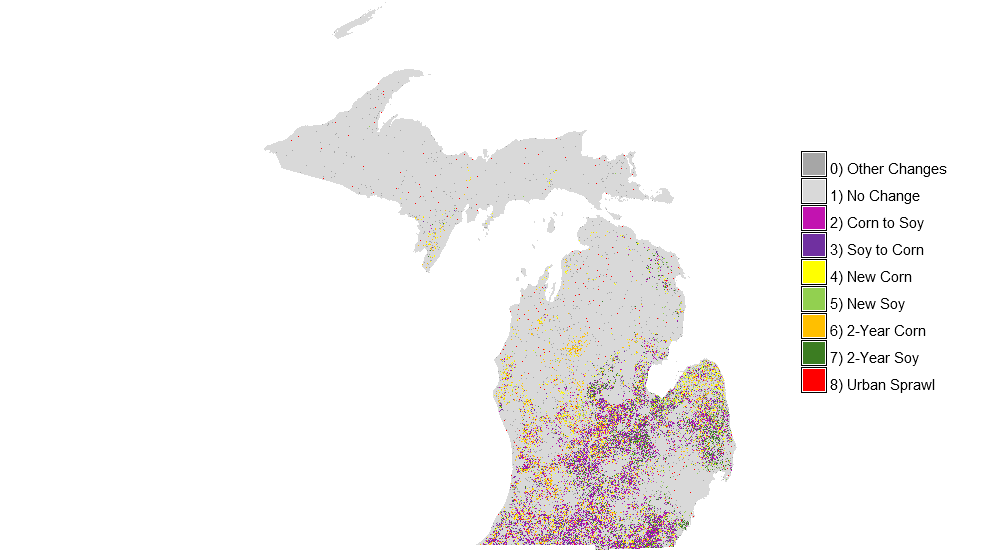

In [10]:
# Create and display map instance
final_map = gj.Map(width=1000, height=550)
final_map.d_rast(map=f'labeled_changes_{base_year}_{base_year+1}')
final_map.d_legend(raster=f'labeled_changes_{base_year}_{base_year+1}', at=(25, 75, 80, 90))
final_map.show()
#final_map.save(f"{layer_name}_rotations_{base_year}_{base_year+1}.png")


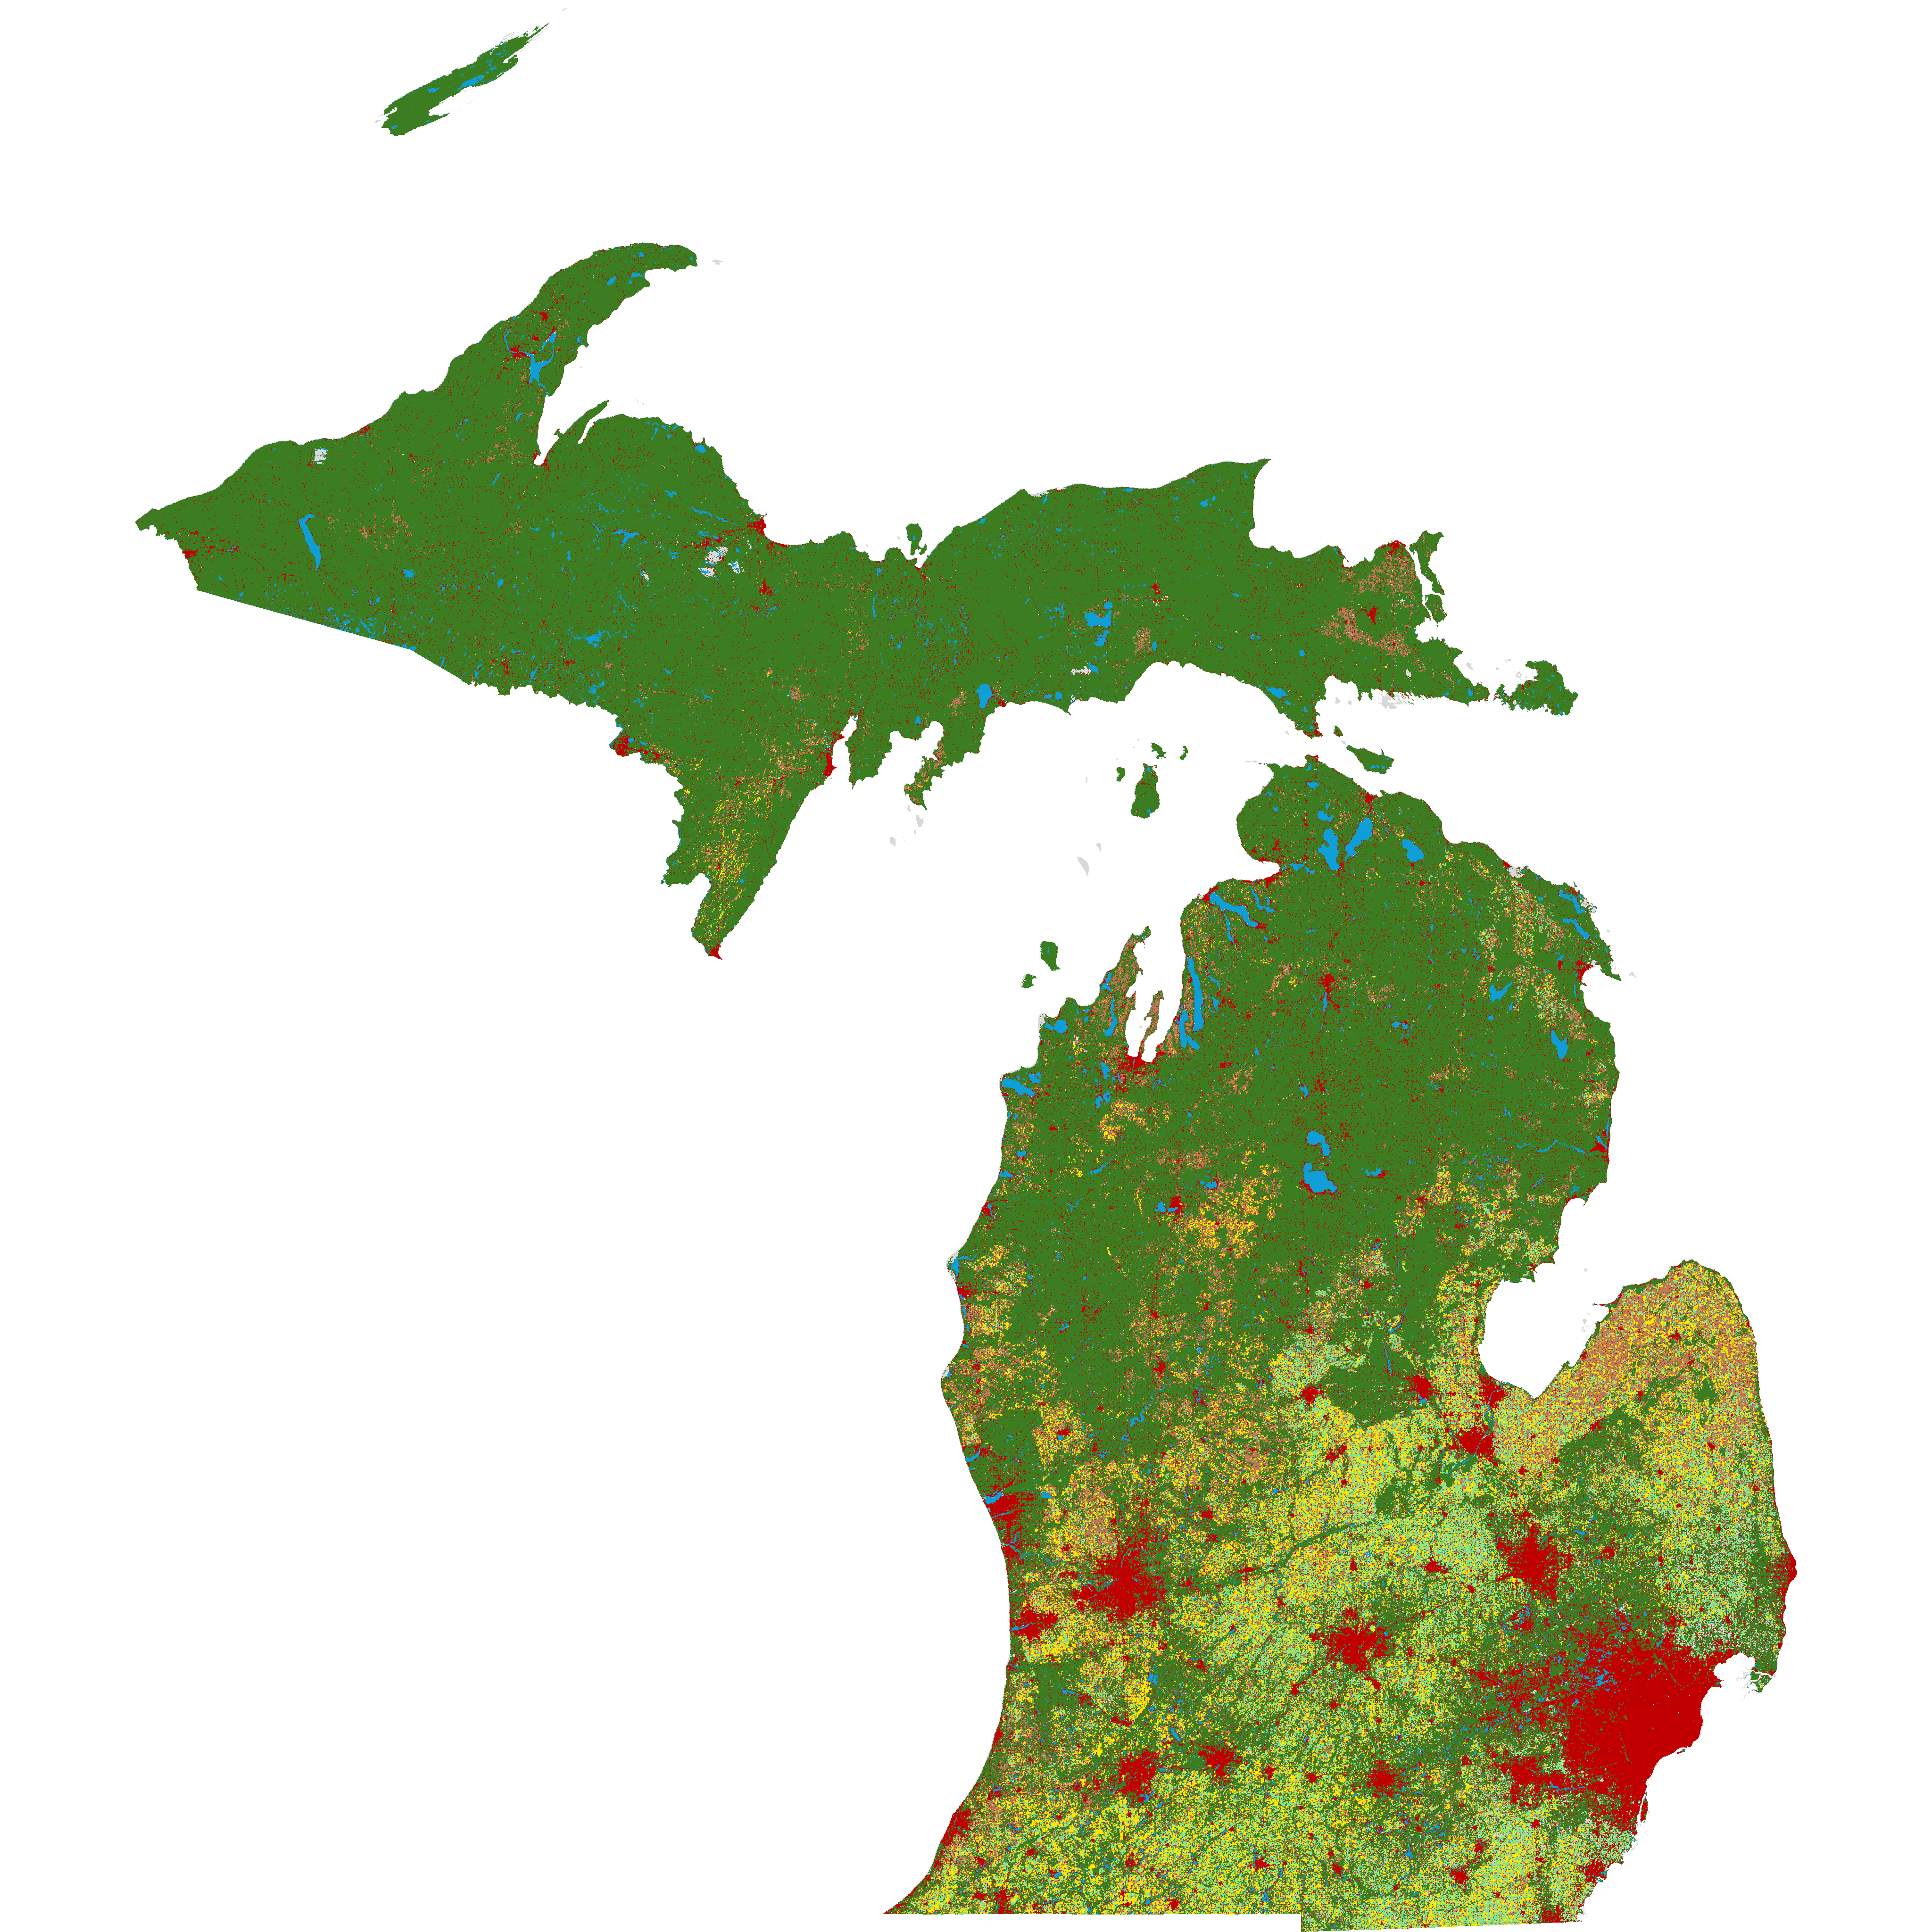
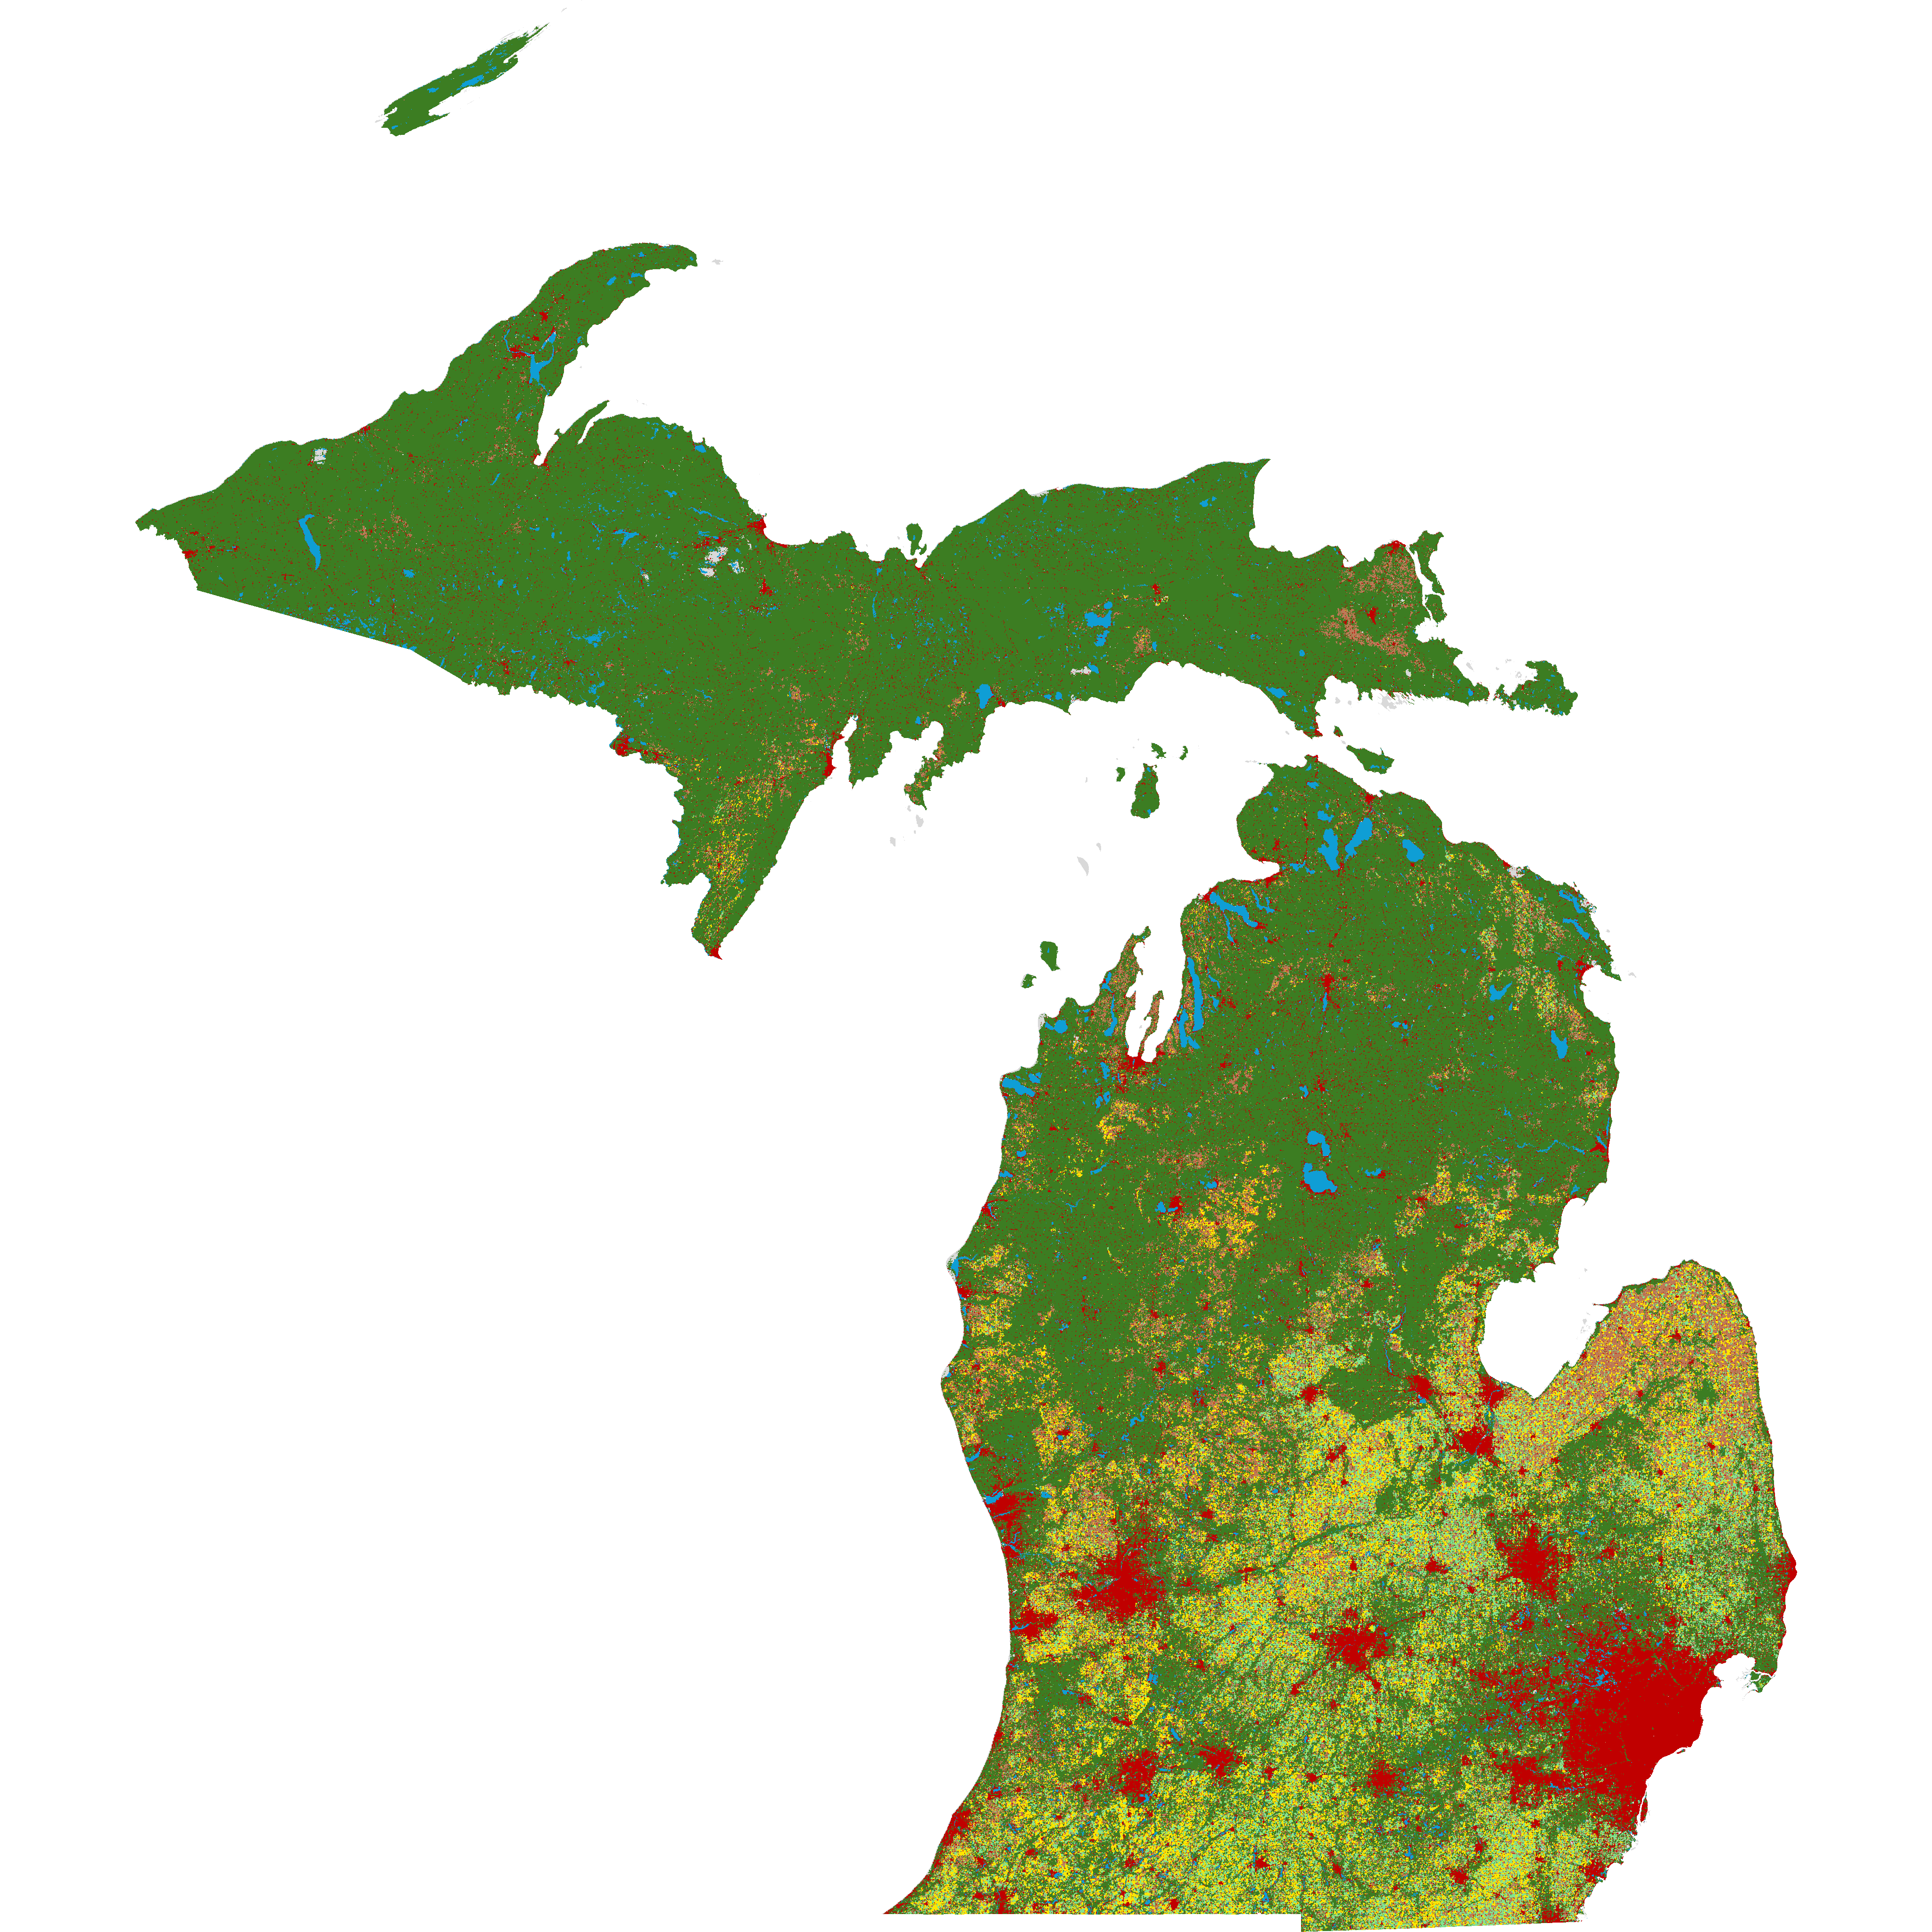
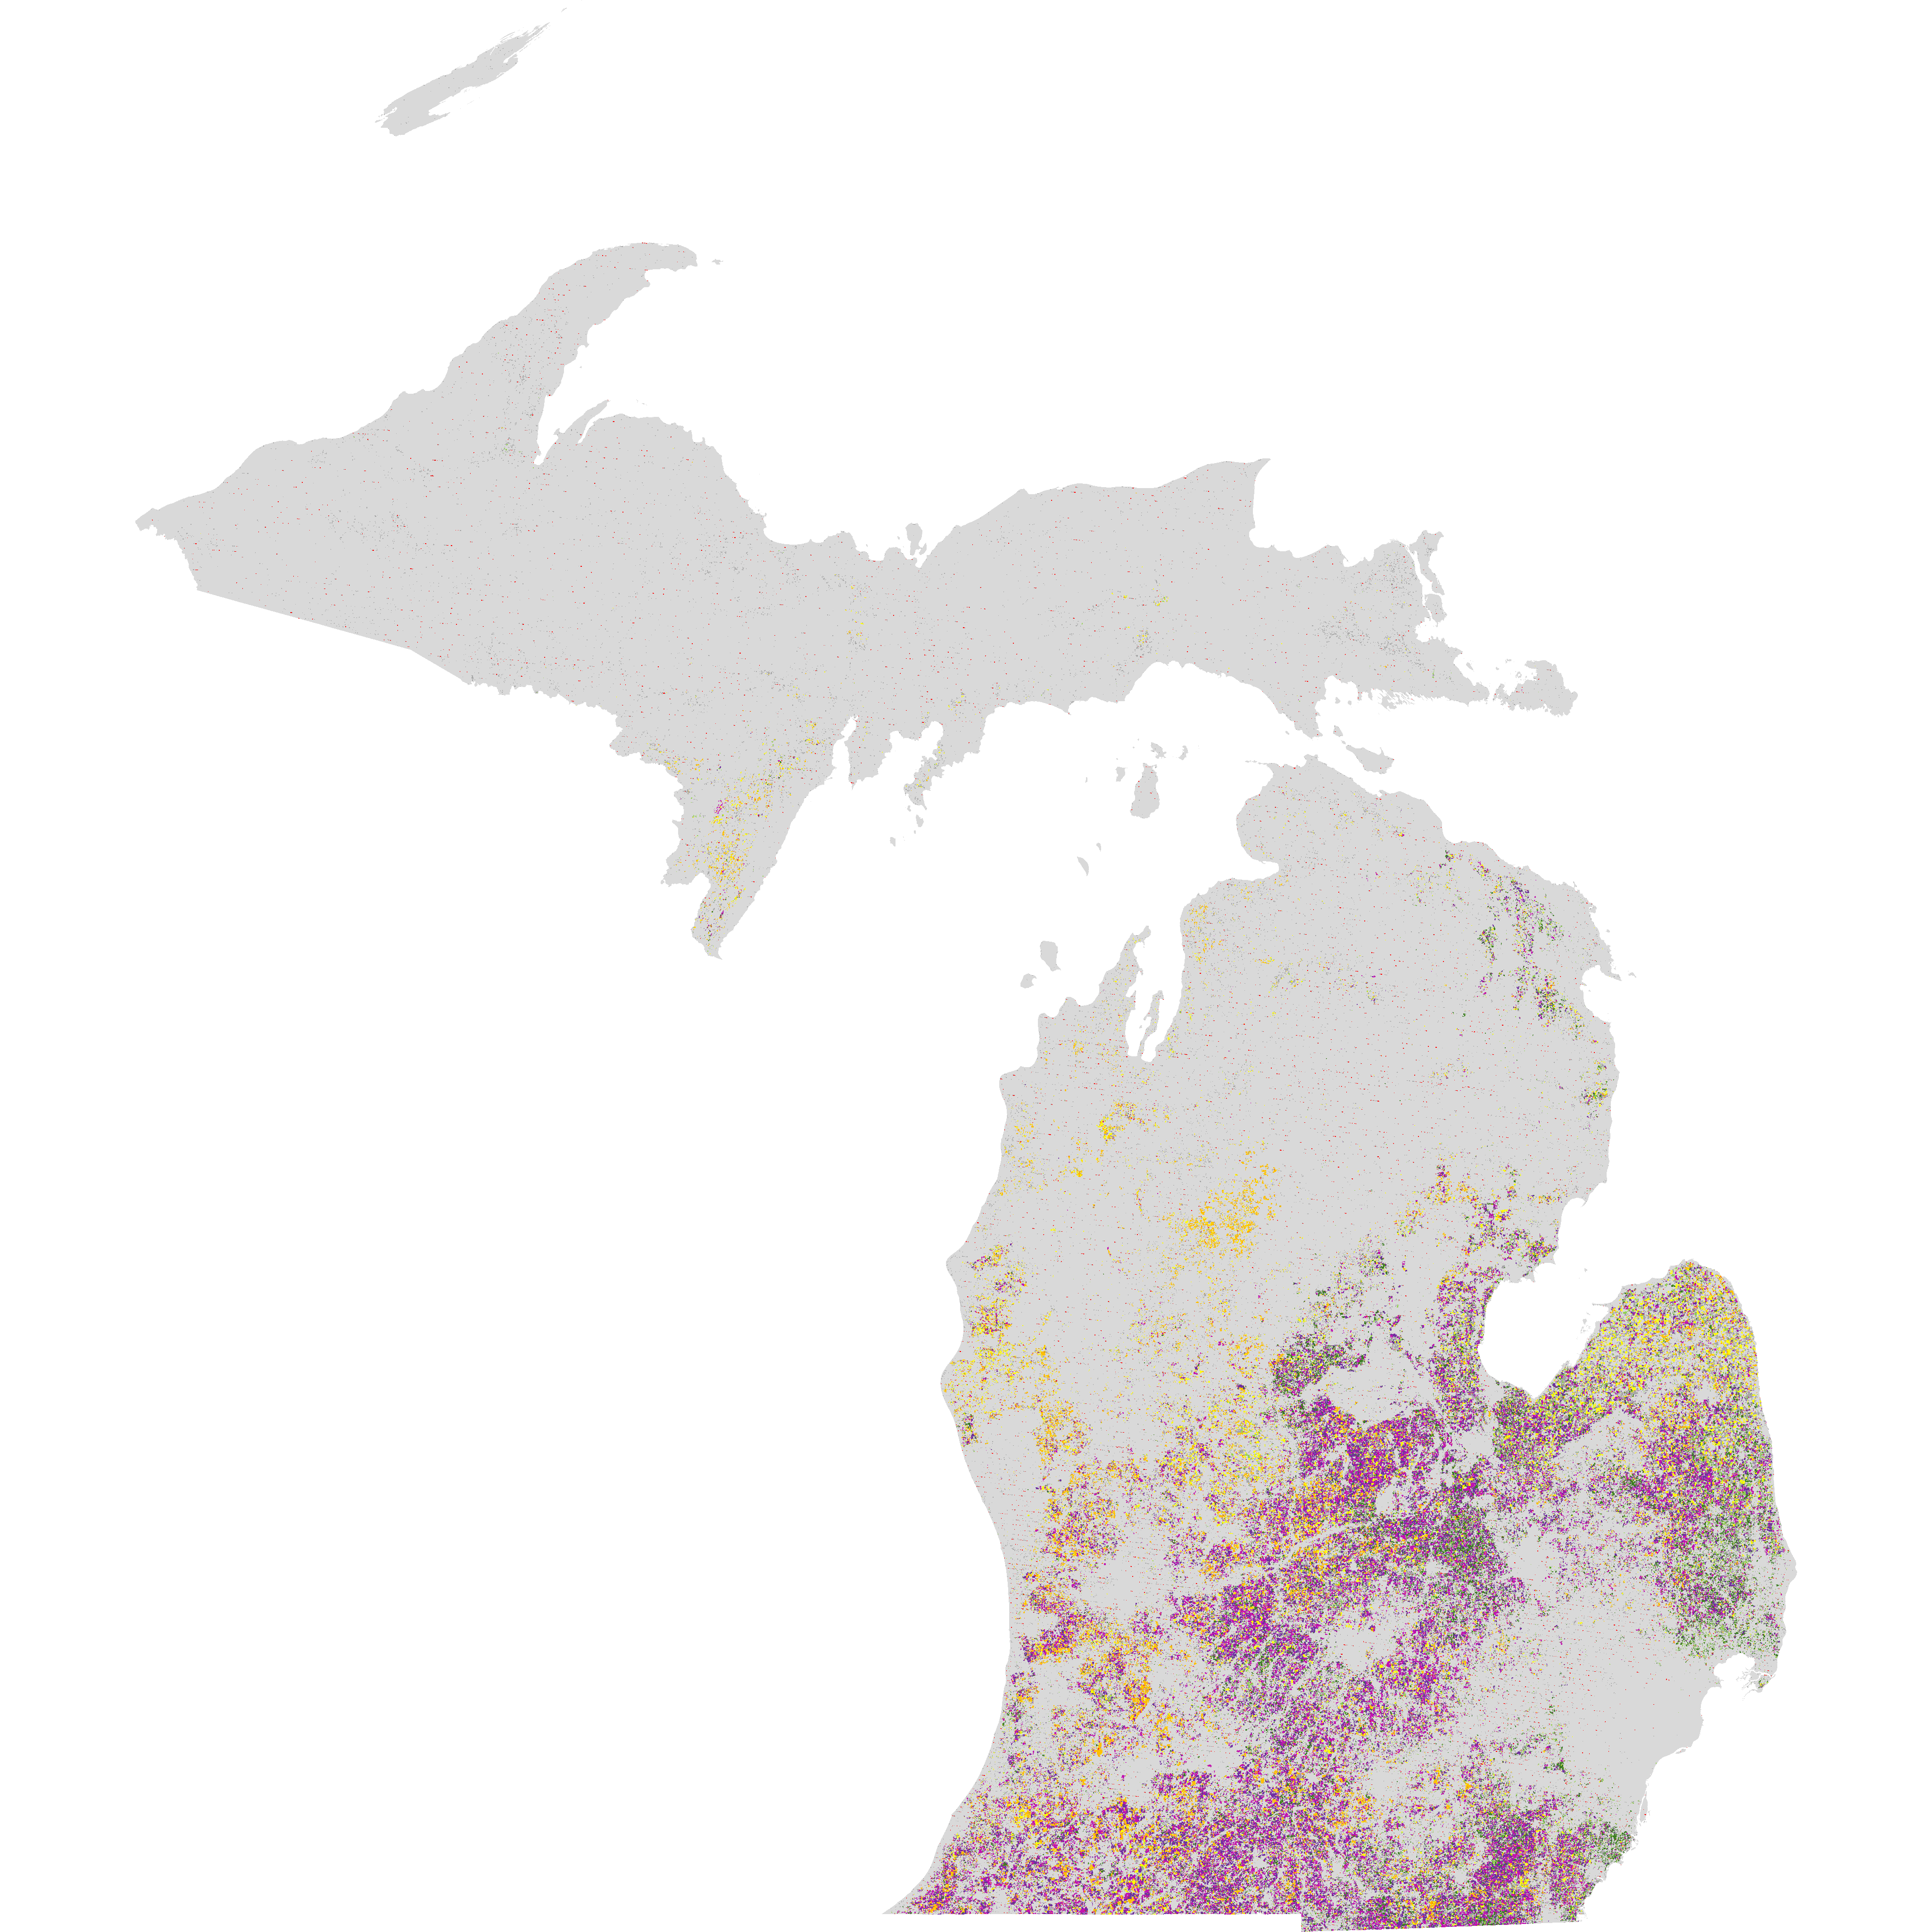

In [11]:
# Create interactive map
int_map = gj.InteractiveMap(width = 1000)
int_map.add_raster(f'reclass_{base_year}', title=f"Layer {base_year}", opacity=1)
int_map.add_raster(f'reclass_{base_year+1}', title=f"Layer {base_year+1}", opacity=1)
int_map.add_raster(f'labeled_changes_{base_year}_{base_year+1}', title="Crop Rotations", opacity=1)
int_map.add_layer_control(position = 'bottomright')
int_map.show()

In [12]:
original_stats_raw = gs.read_command('r.stats', input=f'reclass_{base_year}', separator='comma', flags='acpnl')
next_stats_raw = gs.read_command('r.stats', input=f'reclass_{base_year+1}', separator='comma', flags='acpnl')
rotation_stats_raw = gs.read_command('r.stats', input=f'labeled_changes_{base_year}_{base_year+1}', separator='comma', flags='acpnl')

In [13]:
def create_table(raw_data):

    data_list = []
    rotation = raw_data.split('\r\n')
    
    for string in rotation:
        collection = string.split(',')

        if collection[0] == '': break

        row = [collection[1], collection[2], collection[3], collection[4]]
        data_list.append(row)
        
    return (data_list)

In [14]:
original_data = create_table(original_stats_raw)
next_data = create_table(next_stats_raw)
rotation_data = create_table(rotation_stats_raw)

In [15]:
df_base_year = pd.DataFrame(original_data, columns=['Label', 'Pixel Count', 'Area', 'Perecent of Total'])
df_next_year = pd.DataFrame(next_data, columns=['Label', 'Pixel Count', 'Area', 'Perecent of Total'])
df_changes = pd.DataFrame(rotation_data, columns=['Label', 'Pixel Count', 'Area', 'Perecent of Total'])

In [16]:
df_base_year

Label          Pixel Count     Area Perecent of Total
0     Other/No Data    3860755222.122515    60487             1.31%
1              Corn   19573831748.177738   306666             6.64%
2           Soybean   18726261715.029572   293387             6.35%
3             Water    7026361319.225571   110083             2.38%
4             Urban   31121885686.526413   487591            10.55%
5       Other Crops   20664075270.747498   323747             7.01%
6  Other Vegetation  193931414854.771027  3038351            65.76%

In [17]:
df_next_year

Label          Pixel Count     Area Perecent of Total
0     Other/No Data    2064894806.995279    32351             0.70%
1              Corn   20354956988.456921   318904             6.90%
2           Soybean   18414654146.550819   288505             6.24%
3             Water    7079338435.537226   110913             2.40%
4             Urban   31127247226.008636   487675            10.56%
5       Other Crops   21593536436.701530   338309             7.32%
6  Other Vegetation  194269957776.383087  3043655            65.88%

In [18]:
df_changes

Label          Pixel Count     Area Perecent of Total
0  Other Changes   12217288955.759251   191410             4.14%
1      No Change  242674510675.448669  3802016            82.29%
2    Corn to Soy   10701313667.160553   167659             3.63%
3    Soy to Corn    9674387372.761814   151570             3.28%
4       New Corn    4757281216.961309    74533             1.61%
5        New Soy    2797957675.481602    43836             0.95%
6    2-Year Corn    5923288398.625544    92801             2.01%
7     2-Year Soy    4915382803.833562    77010             1.67%
8   Urban Sprawl    1243175053.502756    19477             0.42%

In [19]:
# Dataframe to Excel Workbook
with pd.ExcelWriter(f'{filename}_statistics.xlsx') as writer:
    df_base_year.to_excel(writer, sheet_name=f"{filename}_{base_year}")
    df_next_year.to_excel(writer, sheet_name=f"{filename}_{base_year+1}")
    df_changes.to_excel(writer, sheet_name=f"{filename}_changes")